# Revenue Optimization with Price Elasticities and Scipy

* See also: [Scipy Optimization Manual](https://docs.scipy.org/doc/scipy/tutorial/optimize.html)

For many simple optimization problems, `scipy.optimize.minimize` ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) from `scipy` is all you need. In this example, we'll use product price elasticities to recommend prices that will optimize revenue when we have:

1. A single product with known price elasticity
2. Multiple products with known price elasticities
3. Multiple products with uncertainty in price elasticities

## Price Elasticity of demand

First - a refresher on price elasticity of demand. Let's say that we have a demand curve $Q = \alpha P^{\beta}$ which describes the demand $Q$ you would see for any given price $P$. $\beta$ is our price elasticity coefficient, and $\alpha$ represents the intercept (aka the amount of total demand for the product if the price was zero).

Below we'll create some simulated data with an elasticity coefficient $\beta=-1.7$ and $\alpha=2000$ and show both the demand and revenue curves:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import List

# price elasticity function

def demand(P, intercept, coef):
    """
    Q = aP^{-B}
    """
    return (intercept * P**(coef))

def revenue(P, intercept, coef):
    """
    Set negative because we have a minimization problem,
    so minimizing _negative_ revenue == maximizing revenue!
    -P*Q = -P * aP^{-B}
    """
    return -P*(intercept * P**(coef))

Next we'll simulate data and display the plots:

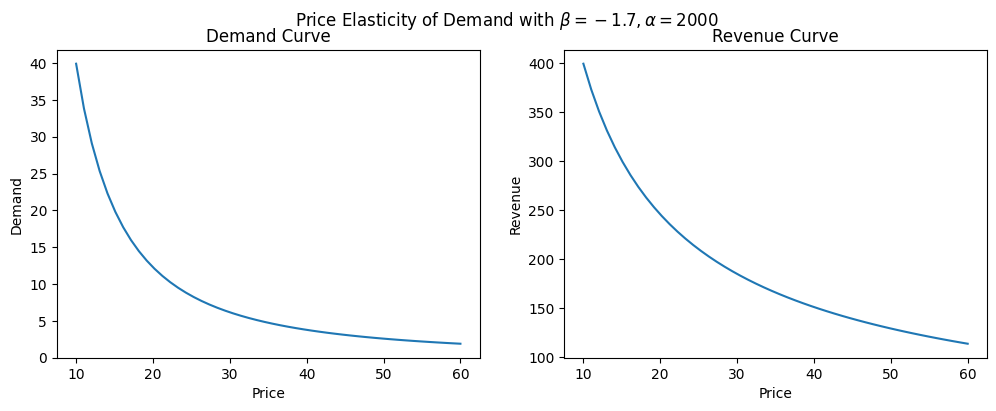

In [2]:
# We can plot this relationship as follows with some simulated data
x = np.linspace(10., 60., 50)
alpha = 2000
beta = -1.7
y = demand(x, alpha, beta)  
y2 = revenue(x, alpha, beta) * -1 # -1 for plotting
f, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(x,y)
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Demand")
ax[0].set_title("Demand Curve")
ax[1].plot(x,y2)
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Revenue")
ax[1].set_title("Revenue Curve")
f.suptitle(r"Price Elasticity of Demand with $\beta=-1.7, \alpha=2000$");

Note the negative sign at the end of the `revenue` function. Since our goal is to *maximize* revenue but we're using the `scipy.optimize.minimize` function, know that minimizing negative revenue is the same as maximizing positive revenue.

## Aside: How to interpret a Log-Log Regression Coefficient

Recall that we can decompose the price elasticity of demand function $Q = \alpha P^{\beta}$ into the sum of log terms and solve for the coefficient $\beta$ in a log-log regression:

$$
\begin{aligned}
Q &= \alpha P^{\beta} \\
\rightarrow \quad \log(Q) &= \beta \log(P) + \log(\alpha)
\end{aligned}
$$

A common interpretation of $\beta$ regression coefficient in a log-log model is that a $1\%$ change in your predictor is associated with a $\beta \%$ change in your outcome variable. So in this example, with $\beta=-1.7$, we would say that a $1\%$ change in price would lead to a $-1.7\%$ change in demand. It's important to note here that this is only an approximation, and moreover this only holds true for an exactly $1\%$ increase in price. So it would not be accurate to say that a $10\%$ increase in price would lead to a $-17\%$ change in demand, nor would it be true that lowering the price $-1\%$ would lead to a $1.7\%$ *increase* in demand!

### Calculating impact

The formula for a percentage change associated with a $d$% change in price (holding everything else constant) is given by the following formula:

$$
\begin{aligned}
\text{pct change in outcome} = e^{\beta \log(1 + d)} - 1
\end{aligned}
$$

where $d$ is the % change in price. 

For example, if we wanted to estimate the percent change in demand $Q$ from a $-10\%$ decrease (aka $d=-0.1$) in price for a product with $\beta=-1.7$, this would be:

$$
\begin{aligned}
e^{-1.7 \log(0.9)} - 1 \approx 0.196
\end{aligned}
$$

which would correspond to a ~$19.6\%$ increase in sales. 

**Notice that this isn't symmetric**, so a 10 percentage point price *increase* for the same product would be associated with a 15% sales *decrease*:

In [3]:
def calc_change(coef:float, d:float)->float:
    """
    Calculate the percentage change in demand given a 
    percent change `d` and elasticity coefficient `coef`
    """
    return np.exp(coef * np.log(1+d)) - 1

calc_change(-1.7, 0.1)  # Returns -0.14958, a 15% sales decrease

-0.1495820170073595

## Optimization for a single product

Next we'll take our baby steps into the `scipy.optimize.minimize` function where we try to find the price that maximizes revenue (minimizes negative revenue) for a *single* product, using the same $\beta=-1.7, \alpha=2000$.

They key components for any optimization problem are:

1. An objective function
2. Constraints

We already specified our objective function `revenue` earlier in code, but now let's write it out explicitly. We're looking to maximize the revenue function $P \times Q$:

$$
\begin{aligned}
\argmax_P P Q &= \argmin_P -P Q\\
\text{where} \quad Q &=\alpha P ^{\beta}
\end{aligned}
$$

Which is just our `revenue` function in math terms. Next, we'll specify our constraints for this problem.

### Adding Inequality Constraints

While `scipy` has stuff like `LinearConstraint`, I'm going to use a bunch of *inequality constraints* that must be either a dictionary or list of dictionaries.

An inequality constraint should be a function of the form $C_j(x) \ge 0$. So if we want to say that $x \ge 10$, then subtract from both sides to get $x - 10 \ge 0$.

Then, we'll need to create a python function that returns $x-10$, and feed that in to our constraint dictionary, i.e:

```python
def f(x):
    return x - 10

# scipy.optimize.minimize expects constraints as dicts with a 'type' ('ineq' or 'eq') and 'fun' function
constraint = {'type':'ineq', 'fun':f}

# Which is equivalent to:
constraint = {'type':'ineq', 'fun':lambda x: x-10}
```

And for multiple constraints, we simply put them together as a `list`:

In [4]:
# For multiple constraints, we make a List[dict]
constraints = [{'type':'ineq', 'fun':lambda x: x - 10},
               {'type':'ineq', 'fun':lambda x: 60 - x}]


Note that from here out I'm going to be using `lambda` functions for brevity.

### Minimize!

We're now ready to optimize our revenue function. Because we're using `minimize`, we had set our objective function `revenue` earlier to return a negative number, which turns this minimization function into a maximization problem. We'll pass in our initial guess `x0=10` and specify the `slope` and `intercept` arguments for the `revenue` function by adding the parameter `args=(alpha, beta)`. 

This will return a optimization result object where we can display and extract useful information:

In [5]:
# minimize revenue with initial guess of 10, args as a tuple, and our list of constraints
res = minimize(revenue, x0=10, args=(alpha, beta), constraints=constraints)
# Display result:
res

     fun: -399.052462993776
     jac: array([27.93367386])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([10.])

In the above result, we can see `res.x` is the optimal price that maximized revenue, and the 'best' revenue it found ended up being around \$399. So for this highly elastic product, the best option is to reduce price as low as possible. 

Now, you might be wondering, what was the point of that? If we inspect the earlier revenue chart, we notice that this product is highly elastic and decreasing the price down to \$10 would give us the highest revenue (around \$400). We could have simply looked at the chart and gotten our answer that way, or used a simple `min.()` to find it. The upside of having `scipy.optimize` in your toolkit is that you can solve more complicated problems and save you the trouble at eyeballing charts!

## Optimization with Multiple Products

Now, we'll start adding some more complexity and go to optimizing revenue for 3 products instead of just one. Imagine we're a simple beverage stand and sell 3 products:

* an entry-level 'Potion'
* a mid-range 'Hi-Potion'
* a high-end 'Max-Potion' for our wealthiest customers

Let's say that we already have point estimates for the price elasticity coefficients, and our data is summarized as:

In [69]:
# Imagine we have 3 products with 3 different elasticities:
coefs = [-2.5, -1.6, -0.7]
prices = [10., 20., 30.]
intercepts = [2000, 2000, 2000]
products = {'product': ['Potion', 'Hi-Potion', 'Mega-Potion'], 
            'price': prices, 
            'elasticity': coefs,
            'intercept': intercepts}
df = pd.DataFrame(products)
df

,product,price,elasticity,intercept
0,Potion,10.0,-2.5,2000
1,Hi-Potion,20.0,-1.6,2000
2,Mega-Potion,30.0,-0.7,2000


We'll update our objective function to now calculate *total* sales for our products and call it `multiple_product_revenue`:

In [70]:
def multiple_product_revenue(P:List[float], intercepts:List[float], coefs:List[float]):
    """
    Calculate total revenue from multiple products, given prices,
    elasticity coefficients, and intercepts
    """
    return -np.sum([p * intercepts[i] * (p**coefs[i]) for i,p in enumerate(P)])

multiple_product_revenue(prices, intercepts, coefs) # -5943.07

-5943.0731842817295

Or
$$
\begin{aligned}
\argmin_P \sum_{i=0}^{2} -P_iQ_i
\end{aligned}
$$


### Adding Constraints

In this case, we want to specify that the prices should follow some tiering logic, where each subsequent product should be priced higher than the previous one. For example, a 'Hi-potion' should be priced at least \$5 higher than the 'Potion', and the 'Mega Potion' should be priced at least \$5 higher than 'Hi-Potion'. 

Following the inequality constraints, this would like:

$$
\begin{aligned}
x_2 \ge x_1 + 10 \rightarrow \quad x_2 - x_1 - 10 &\ge 0\\
x_1 \ge x_0 + 10 \rightarrow \quad x_1 - x_0 - 10 &\ge 0
\end{aligned}
$$

We also need to specify some upper and lower bounds on this too, otherwise for highly elastic products the optimum will be too low, and conversely for highly inelastic products we want an upper bound or the optimizer will recommend an infinite price.

$$
\begin{aligned}
x_0 \ge 10 \rightarrow \quad x_0 - 10 &\ge 0\\
x_2 \le 60 \rightarrow \quad 60 - x_2 &\ge 0\\
\end{aligned}
$$

We'll add the rest of the constraints as `lambda` functions and then add all of the constraints as a list of dictionaries:

In [71]:
# Multiple Constraints should be a list of dictionaries and we can use lambda functions instead

cons = [{'type':'ineq', 'fun':lambda x: x[2] - x[1] - 10},
        {'type':'ineq', 'fun':lambda x: x[1] - x[0] - 10},
        {'type':'ineq', 'fun':lambda x: x[0] - 10},
        {'type':'ineq', 'fun':lambda x: 60 - x[2]}] # Upper bound

In [73]:
# minimize call
multiple_res = minimize(multiple_product_revenue, x0=prices, 
                        args=(intercepts, coefs), constraints=cons)
multiple_res

     fun: -7225.550739696924
     jac: array([  9.48681641,   9.94335938, -34.15441895])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([10., 20., 60.])

We see that it recommended prices of 10, 20, and 60 for our products for an optimal revenue of 7226. Much better than our baseline of 5943!

Recall that the first two products were highly price elastic so it recommended a lower price, while the product with low price elasticity gets a higher recommended price. And of course, this doesn't take into account cross-price elasticities, other features that could drive sales, and other real-world concerns, but this should be sufficient.

## Optimize Multiple Products with Uncertainty in our Elasiticity Coefficients

What if there was uncertainty in our elasticity coefficient estimates (i.e. epistemic uncertainty)? 

We could simply take the average coefficient estimate and use that as a point estimate, but in our pricing decision we may instead want to choose a different strategy, like minimax or maximin, etc. 

For this example we'll maximize *expected* revenue given a range of various coefficients that are normally distributed:

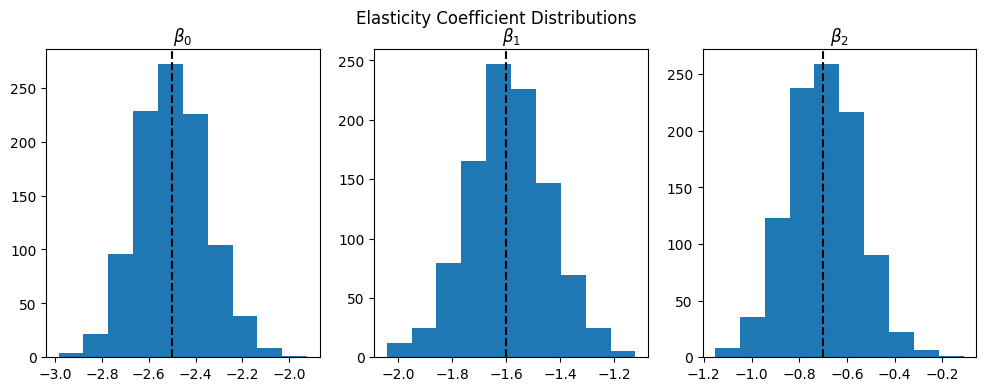

In [74]:
np.random.seed(42)

def simulate_coefficients(coefs:List[float], num_samples=1000)->np.ndarray:
    # Simulate random draws of a number of coefficients
    coef_samples = np.zeros((num_samples, len(coefs))) # (n,k)
    std_dev = 0.15
    for i,c in enumerate(coefs):
        coef_samples[:, i] = np.random.normal(c, std_dev, num_samples)
    return coef_samples

# Get a 2D array of shape (1000, 3) of coefficient samples
coef_samples = simulate_coefficients(coefs, 1000)
f, ax = plt.subplots(1,3, figsize=(12,4))
for i in range(3):
    ax[i].axvline(coefs[i], c='black', linestyle='--')
    ax[i].hist(coef_samples[:, i])
    ax[i].set_title(rf"$\beta_{i}$")
f.suptitle("Elasticity Coefficient Distributions");

Next we'll need to restate our objective function because instead of having a list of 3 coefficients, now we have 1000 samples from each of the coefficient distributions in a $(1000, 3)$ array, where each row represents a sample of each of the coefficients and each column is a different coefficient/product.

Since each row is a distinct combination of samples from these three distributions, we can calculate sales for each of the 1000 combinations of coefficients and get the average for a given product price scenario. 

In [75]:
def uncertain_revenues(prices:List[float], 
                       coef_samples:np.ndarray, 
                       intercepts:List[float],
                       agg_func=np.mean):
    """
    Calculate Total Sales for each of the independent samples
    """
    demand_array = np.zeros(coef_samples.shape)
    revenue_array = np.zeros(coef_samples.shape)

    # Iterate for each product to calucate product sales for each
    # sample of its elasticity coefficient
    for i,p in enumerate(prices):
        # Calculate Demand and Revenue for a single product
        _demands = intercepts[i] * p**(coef_samples[:, i])
        demand_array[:,i] = _demands
        revenue_array[:, i] = p * _demands

    # To get total revenue, we sum the individual product revenues
    # by summing each row in our (n, P) revenue matrix
    total_revenues = np.sum(revenue_array, axis=1) # (n,) revenues 
    if agg_func=='None':
        return -total_revenues
    else:
        return -agg_func(total_revenues)

Before we run this optimization problem, we can look at the distribution of total sales with our new coefficient samples and baseline prices ($P=[10,20,30]$)

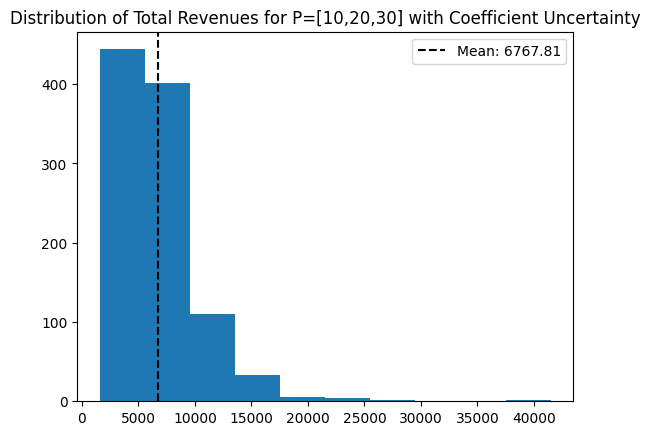

In [76]:
total_revenues = uncertain_revenues(prices, coef_samples, intercepts, agg_func='None')

# Plot
plt.hist(total_revenues * -1)
mean_revenue = np.mean(total_revenues * -1)
plt.axvline(mean_revenue, c='black', linestyle='--',
            label=f"Mean: {np.round(mean_revenue,2)}")
plt.legend()
plt.title("Distribution of Total Revenues for P=[10,20,30] with Coefficient Uncertainty");

Note that the average sales is quite a bit higher than if we had just used the point estimates for the $\beta$ price elasticity coefficients at the same prices. 

Finally, we take our new total revenue function `uncertain_revenues` and plug it in to the `scipy.optimize.minimize` function with the same constraints as before:

In [77]:
# minimize call
uncertain_res = minimize(uncertain_revenues, x0=prices, 
                         args=(coef_samples, intercepts, np.mean), 
                         constraints=cons)
uncertain_res

     fun: -8700.021202981006
     jac: array([  9.75854492,   9.88623047, -54.04797363])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([10., 20., 60.])

And interestingly enough, we arrive at the same recommendation, but now we have a higher optimal value thanks to the variation in our coefficient estimates. 

## Trying alternate strategies

Recall that the `uncertain_revenues` function we made earlier had an argument called `agg_func` to specify the aggregation methodology. When we maximized expected revenue, we took the mean of the revenues but we can go a little further and modify our objective function to provide the prices that maximize the *maximum* revenue instead of the expected/mean revenue. This is the "maximax" strategy, where we wish to find the prices that maximize the "best case" revenue:

In [80]:
minimize(uncertain_revenues, x0=prices, 
         args=(coef_samples, intercepts, np.max), 
         constraints=cons)

     fun: -76513.68494954193
     jac: array([   11.09960938,     9.19921875, -1128.265625  ])
 message: 'Optimization terminated successfully'
    nfev: 9
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([10.        , 20.        , 59.99999999])

Or conversely there's the 'maximin' strategy in which we want to find the prices that give us the best of the worst case scenarios:

In [79]:
minimize(uncertain_revenues, x0=prices, 
         args=(coef_samples, intercepts, np.min), 
         constraints=cons)

     fun: -1583.1352057625413
     jac: array([7.98712158, 9.88525391, 5.97763062])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([10., 20., 30.])

## Summary

The `scipy.optimize.minimize` function is a powerful tool in your optimization toolkit that can help solve both linear and nonlinear optimization problems with a very simple interface. It takes in an arbitrary function (which in this case was quadratric) and a list of constraints and then it does all the magic behind the scenes. For simple business problems like this product pricing example, I found `minimize` to be an ideal mix between performance and ease of use. The easy stuff is easy - but as things get more complicated, (i.e. mixed integer problems, network optimization, etc) you'll need to reach out to more advanced libraries like Google's `or-tools` ([link](https://developers.google.com/optimization)).